In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recommendations

In [2]:
df = pd.read_csv('processed_dataset.csv')
df = df[['Student Number', 'Course Code', 'Letter Grade', 'Semester']]
df

,Student Number,Course Code,Letter Grade,Semester
0,351,UNI 123,A+,2011 - Fall
1,1182,MGT 511,A-,2011 - Fall
2,1182,MGT 521,B+,2011 - Fall
3,1181,MGT 521,B+,2011 - Fall
4,1181,MGT 531,B+,2011 - Fall
...,...,...,...,...
49342,2003,IE 451,B+,2014 - Spring
49343,1311,ENGR 251,A-,2014 - Spring
49344,2003,EE 321,B,2014 - Spring
49345,173,CTV 212,C+,2014 - Spring


In [3]:
numerical_grades = {'A+': 4.1, 'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7, 'C+': 2.3, 'C': 2.0,
                    'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'D-': 0.5, 'F': 0.0}

In [4]:
semester_data = {}
for row_idx in df.index:
    student_number = df.iloc[row_idx, 0]
    course_code = df.iloc[row_idx, 1]
    letter_grade = df.iloc[row_idx, 2]
    semester = df.iloc[row_idx, 3]
    
    semester_data.setdefault(semester, {})
    semester_data[semester].setdefault(student_number, {})
    semester_data[semester][student_number][course_code] = numerical_grades[letter_grade]

In order to assess the accuracy of the model, we use Root Mean Squared Error (RMSE) which is defined as: 

$$\large \text{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2}$$


Moreover, $R^2$ statistics is used which measures the proportion
of variability in Y that can be explained using X. An $R^2$ statistic that is
close to 1 indicates that a large proportion of the variability in the response
has been explained by the regression. A number near 0 indicates that the
regression did not explain much of the variability in the response; this might
occur because the linear model is wrong, or the inherent error $σ^2$ is high,
or both.

$$\large R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

In [5]:
def get_errors(train_semester, test_semester, sim):
    predictions = []
    y_true_total = 0
    rss = 0   # residual sum of squares
    for student in train_semester:
        recs = recommendations.getRecommendations(train_semester, student, sim)
        for rec_numerical, rec_course in recs:
            if student in test_semester:
                if rec_course in test_semester[student]:
                    y_true_total += test_semester[student][rec_course]
                    rss += pow((test_semester[student][rec_course] - rec_numerical), 2)
                    predictions.append(rec_numerical)
    
    rmse = np.sqrt(rss / len(predictions))
    
    tss = 0   # total sum of squares
    y_true_avg = y_true_total / len(predictions)
    for rec_numerical in predictions:
        tss += pow(rec_numerical - y_true_avg, 2)
    r2_score = 1 - (rss / tss)
    
    return rmse, r2_score

In [6]:
def predict(semester_data, sim):
    errors = {'rmse': [], 'r2 score': []}
    for i in range(len(sorted(semester_data))-1):
        if i == 0:
            train_semester = semester_data[sorted(semester_data)[i]]
        else:
            new_semester = semester_data[sorted(semester_data)[i]]
            for student in new_semester:
                if student in train_semester:
                    train_semester[student].update(new_semester[student])
                else:
                    train_semester[student] = new_semester[student]
        test_semester = semester_data[sorted(semester_data)[i+1]]

        # making predictions for every student in training semester
        rmse, r2_score = get_errors(train_semester, test_semester, sim)

        errors['rmse'].append(rmse)
        errors['r2 score'].append(r2_score)
    
    return errors

In [7]:
def plot_errors(errors, sim):
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(11, 5.5))
    rects1 = ax.bar(x - 0.35/2, errors['rmse'], 0.35, label='RMSE')
    rects2 = ax.bar(x + 0.35/2, errors['r2 score'], 0.35, label='R\u00b2 Statistics')
    for i, v in enumerate(errors['rmse']):
        ax.text(i-0.36, v + 0.03, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    for i, v in enumerate(errors['r2 score']):
        ax.text(i-0.08, v - 0.23, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    ax.set_ylabel('Error', fontsize=22, fontfamily='serif')
    ax.set_title('Error Metrics with N training semesters ({})'.format(sim), fontsize=22, fontfamily='serif')
    ax.set_xticks(x)
    ax.set_xticklabels(['N={}'.format(i+1) for i in range(7)], fontsize=22, fontfamily='serif')
    ax.set_yticklabels(ax.get_yticks(), fontsize=22, fontfamily='serif')
    ax.tick_params(labelsize=22)
    ax.grid(True)
    ax.legend(prop={'size': 18, 'family': 'serif'}, loc='lower left')

The euclidean distance between all points $p$ and $q$ are given by:

$$\large d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$$

where d( $p$,$q$ ) is 0 when $p$ = $q$. In order to show a high numerical value for close points, we make the following division:

$$\large d\left( p,q\right)   = \frac{1}{1 + d\left( p,q\right)}$$

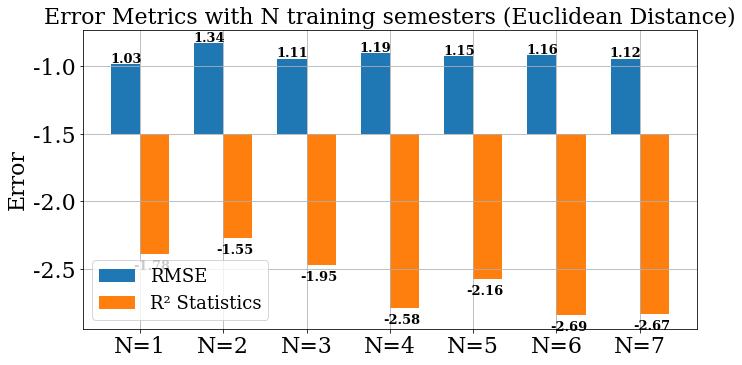

In [8]:
errors = predict(semester_data, recommendations.sim_distance)
plot_errors(errors, 'Euclidean Distance')

The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient, is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

$$\large J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

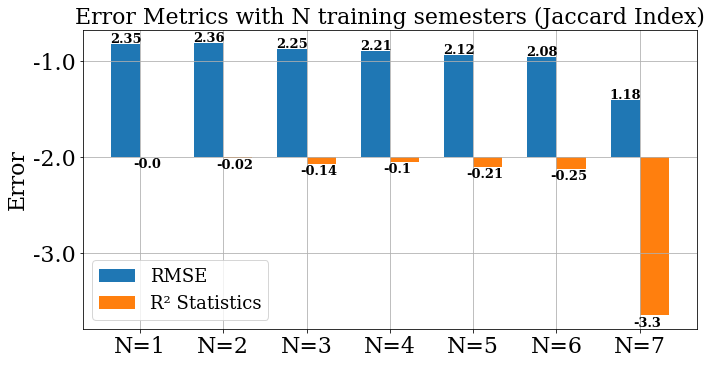

In [9]:
errors = predict(semester_data, recommendations.sim_jaccard)
plot_errors(errors, 'Jaccard Index')

The correlation coefficient is a measure of how well two sets of data fit on a straight line. The formula for this is more complicated than the Euclidean distance score, but it tends to give better results in situations where the data isn’t well normalized. 


$$\large r=\frac{n(\sum xy)-(\sum x)(\sum y)}{\sqrt{[n\sum x^{2}-(\sum x)^{2}][n\sum y^{2}-(\sum y)^{2}]}}$$

where $x$ corresponds to values in the first set of data and $y$ corresponds to the other one. $n$ determines the total number of samples.

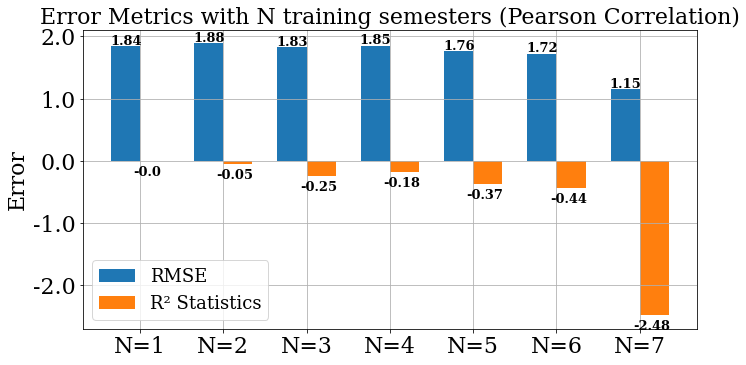

In [10]:
errors = predict(semester_data, recommendations.sim_pearson)
plot_errors(errors, 'Pearson Correlation')